In [112]:
import pandas as pd
import pymongo
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [120]:
def connect_mongodb(uri="mongodb://localhost:27017/"):
    client = pymongo.MongoClient(uri)
    return client.ble_scanner.adv_5_min

# Función para consultar datos por rango de fechas
def query_data_by_date(collection, start_date, end_date):
    query = {
        "timestamp": {
            "$gte": start_date,
            "$lte": end_date
        }
    }
    return list(collection.find(query))

In [114]:
def basic_analysis(df, start_date, end_date):
    print(f"Análisis para el período: {start_date} a {end_date}")
    print("-" * 50)
    
    # 1. Número total de muestras
    total_samples = len(df)
    print(f"Número total de muestras: {total_samples}")
    
    # 2. Número de MACs distintas
    unique_macs = df['mac'].nunique()
    print(f"Número de MACs distintas: {unique_macs}")
    
    # 3. Listado de MACs y frecuencia
    mac_counts = df['mac'].value_counts()
    print("\nTop 10 MACs más frecuentes:")
    print(mac_counts.head(10))
    
    # 4. Chequeo de secuencia
    sequence_gaps = check_sequence_gaps(df)
    if sequence_gaps:
        print("\nPérdidas de secuencia detectadas:")
        for gap in sequence_gaps[:10]:  # Mostrar solo los primeros 10 gaps
            print(f"Salto de secuencia: {gap['from']} -> {gap['to']}")
    else:
        print("\nNo se detectaron pérdidas de secuencia")
    
    # Visualización de datos
    plt.figure(figsize=(12, 6))
    df['timestamp'].hist(bins=50)
    plt.title('Distribución temporal de las muestras')
    plt.xlabel('Timestamp')
    plt.ylabel('Frecuencia')
    plt.show()
    
    return {
        'total_samples': total_samples,
        'unique_macs': unique_macs,
        'mac_counts': mac_counts,
        'sequence_gaps': sequence_gaps
    }

In [115]:
def check_sequence_gaps(df):
    gaps = []
    df_sorted = df.sort_values('timestamp')
    
    prev_seq = None
    for _, row in df_sorted.iterrows():
        curr_seq = row['sequence']
        
        if prev_seq is not None:
            expected_seq = (prev_seq + 1) % 256
            if curr_seq != expected_seq:
                gaps.append({
                    'from': prev_seq,
                    'to': curr_seq,
                    'timestamp': row['timestamp']
                })
        prev_seq = curr_seq
    
    return gaps
def export_to_csv(data, filename="ble_data2.csv"):
    """
    Convierte los datos de MongoDB a un DataFrame y los exporta a CSV
    Args:
        data: Lista de documentos de MongoDB
        filename: Nombre del archivo CSV a crear
    Returns:
        DataFrame con los datos
    """
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Datos exportados a {filename}")
    return df

Consultando datos entre:
Inicio: 2024-12-13 10:00:00
Fin: 2024-12-13 11:00:00
Registros encontrados: 38259
Datos exportados a ble_data2.csv

Columnas en el DataFrame:
Index(['_id', 'timestamp', 'sequence', 'mac', 'addr_type', 'adv_type', 'rssi',
       'data_len', 'data'],
      dtype='object')

Primeros registros:
                        _id               timestamp  sequence  \
0  675bfd2311ddc0f30df944ae 2024-12-13 10:23:47.614         0   
1  675bfd2311ddc0f30df944af 2024-12-13 10:23:47.647         1   
2  675bfd2311ddc0f30df944b0 2024-12-13 10:23:47.649         2   
3  675bfd2311ddc0f30df944b1 2024-12-13 10:23:47.655         3   
4  675bfd2311ddc0f30df944b2 2024-12-13 10:23:47.662         4   

                 mac  addr_type  adv_type  rssi  data_len  \
0  77:67:DA:3C:71:74          1         2   -62        31   
1  44:45:76:79:AC:23          1         3   -58        31   
2  89:CC:DB:17:8E:38          1         3   -64        31   
3  98:ED:0B:C8:A5:CF          1         3   -71 

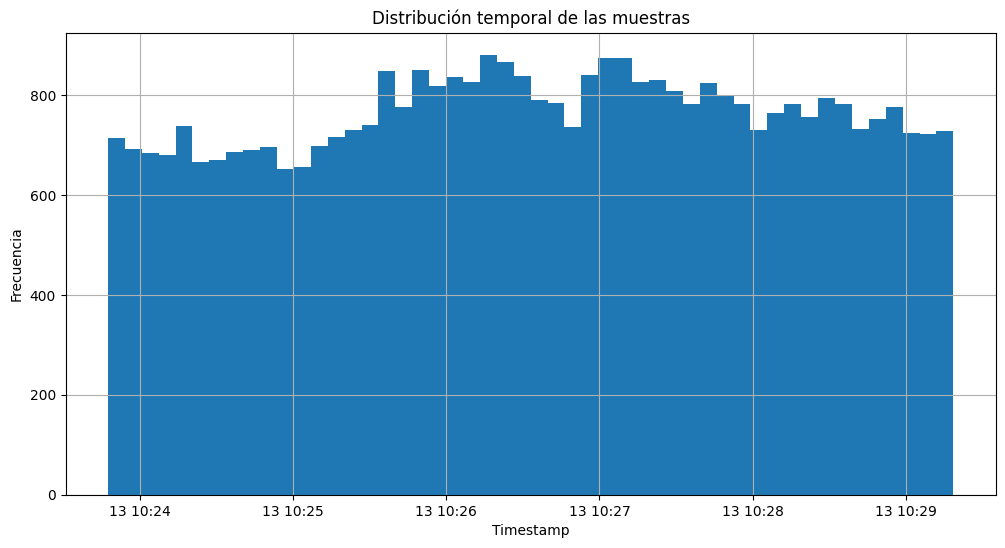

In [123]:
  # Conectar a MongoDB
collection = connect_mongodb()

# Definir rango de fechas para la consulta basado en los datos disponibles
start_date = datetime(2024, 12, 13, 10, 0, 0)  # Basado en el primer registro
end_date = datetime(2024, 12, 13, 11, 0, 0)    # Basado en el último registro

print(f"Consultando datos entre:")
print(f"Inicio: {start_date}")
print(f"Fin: {end_date}")

# Obtener datos
data = query_data_by_date(collection, start_date, end_date)
print(f"Registros encontrados: {len(data)}")

if len(data) > 0:
    # Exportar a CSV
    df = export_to_csv(data)
    
    # Verificar las columnas del DataFrame
    print("\nColumnas en el DataFrame:")
    print(df.columns)
    
    # Verificar los primeros registros
    print("\nPrimeros registros:")
    print(df.head())
    
    # Realizar análisis
    analysis_results = basic_analysis(df, start_date, end_date)
else:
    print("No se encontraron datos en el rango especificado") 

In [121]:
# 1. Verificar la conexión
def test_mongodb_connection():
    try:
        collection = connect_mongodb()
        # Intentar hacer una consulta simple
        count = collection.count_documents({})
        print(f"Conexión exitosa. Total de documentos en la colección: {count}")
        
        # Mostrar un documento de ejemplo si existe
        if count > 0:
            print("\nEjemplo de documento:")
            print(collection.find_one())
        
        return collection
    except Exception as e:
        print(f"Error de conexión: {e}")
        return None

# 2. Verificar el rango de fechas
def verify_date_range(collection):
    if collection is not None:  # Cambiado aquí
        # Encontrar el primer y último documento por timestamp
        first = collection.find_one({}, sort=[("timestamp", 1)])
        last = collection.find_one({}, sort=[("timestamp", -1)])
        
        if first and last:
            print("\nRango de fechas disponible:")
            print(f"Primer registro: {first['timestamp']}")
            print(f"Último registro: {last['timestamp']}")
        else:
            print("No se encontraron documentos con timestamp")

# Ejecutar las verificaciones
collection = test_mongodb_connection()
verify_date_range(collection)

# 3. Verificar la consulta específica
if collection is not None:  # Agregado esta verificación
    end_date = datetime.now()
    start_date = end_date - timedelta(hours=1)

    print(f"\nConsultando datos entre:")
    print(f"Inicio: {start_date}")
    print(f"Fin: {end_date}")

    data = query_data_by_date(collection, start_date, end_date)
    print(f"\nRegistros encontrados en el rango especificado: {len(data)}")

    if len(data) > 0:
        print("\nPrimer registro de la consulta:")
        print(data[0])

Conexión exitosa. Total de documentos en la colección: 38259

Ejemplo de documento:
{'_id': ObjectId('675bfd2311ddc0f30df944ae'), 'timestamp': datetime.datetime(2024, 12, 13, 10, 23, 47, 614000), 'sequence': 0, 'mac': '77:67:DA:3C:71:74', 'addr_type': 1, 'adv_type': 2, 'rssi': -62, 'data_len': 31, 'data': '1eff4c000719010f2003778f04000599b19f5f7214a8914350f9a5e67f649b'}

Rango de fechas disponible:
Primer registro: 2024-12-13 10:23:47.614000
Último registro: 2024-12-13 10:29:18.509000

Consultando datos entre:
Inicio: 2024-12-16 10:57:24.982227
Fin: 2024-12-16 11:57:24.982227

Registros encontrados en el rango especificado: 0



Estadísticas de MACs únicas por intervalo de 5 segundos:
--------------------------------------------------
Promedio de MACs únicas: 41.07
Máximo de MACs únicas: 50
Mínimo de MACs únicas: 32
Mediana de MACs únicas: 41.0


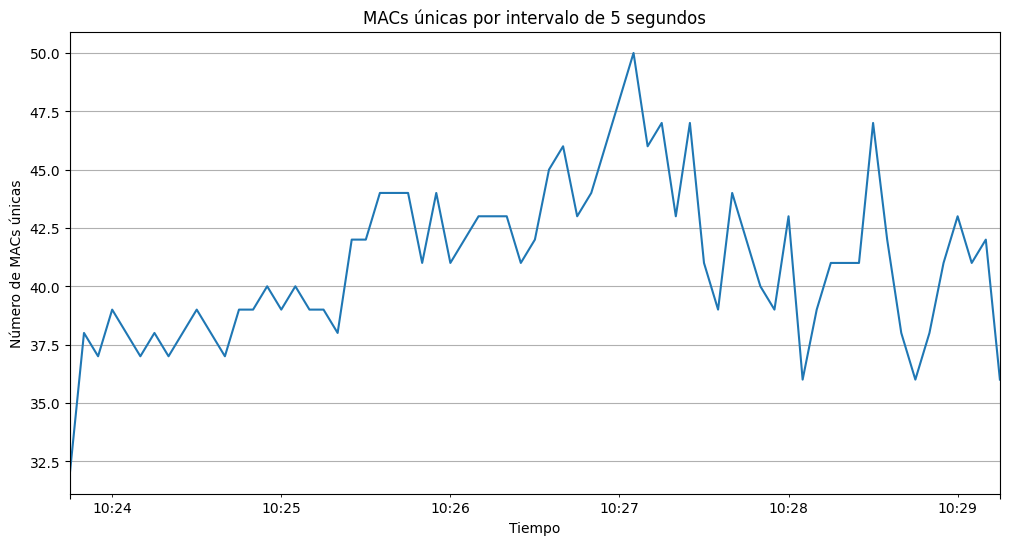

In [124]:

def analyze_macs_per_5seconds(df):
    """
    Analiza las MACs distintas en intervalos de 5 segundos
    
    Args:
        df: DataFrame con los datos, debe contener columnas 'timestamp' y 'mac'
    """
    # Asegurar que timestamp es datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Agrupar por intervalos de 5 segundos y contar MACs únicas
    unique_macs_per_interval = df.groupby(pd.Grouper(key='timestamp', freq='5s'))['mac'].nunique()
    
    # Estadísticas básicas
    print("\nEstadísticas de MACs únicas por intervalo de 5 segundos:")
    print("-" * 50)
    print(f"Promedio de MACs únicas: {unique_macs_per_interval.mean():.2f}")
    print(f"Máximo de MACs únicas: {unique_macs_per_interval.max()}")
    print(f"Mínimo de MACs únicas: {unique_macs_per_interval.min()}")
    print(f"Mediana de MACs únicas: {unique_macs_per_interval.median()}")
    
    # Visualización
    plt.figure(figsize=(12, 6))
    unique_macs_per_interval.plot(kind='line')
    plt.title('MACs únicas por intervalo de 5 segundos')
    plt.xlabel('Tiempo')
    plt.ylabel('Número de MACs únicas')
    plt.grid(True)
    plt.show()
    
    return unique_macs_per_interval

# Usar la función:
mac_analysis = analyze_macs_per_5seconds(df)

In [33]:
def analyze_mac_frequencies(df):
    """
    Analiza y visualiza la relación entre MACs y sus frecuencias
    """
    # Calcular frecuencias de MACs
    mac_freq = df['mac'].value_counts()
    
    # Estadísticas básicas
    print("\nEstadísticas de frecuencia de MACs:")
    print("-" * 50)
    print(f"Total MACs únicas: {len(mac_freq)}")
    print(f"MAC más frecuente: {mac_freq.index[0]} ({mac_freq.iloc[0]} apariciones)")
    print(f"Frecuencia media: {mac_freq.mean():.2f}")
    print(f"Frecuencia mediana: {mac_freq.median():.2f}")
    
    # Crear visualizaciones
    plt.figure(figsize=(15, 10))
    
    # 1. Gráfico de barras para las top N MACs
    plt.subplot(2, 2, 1)
    top_n = 10
    mac_freq.head(top_n).plot(kind='bar')
    plt.title(f'Top {top_n} MACs más frecuentes')
    plt.xlabel('Dirección MAC')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    
    # 2. Histograma de frecuencias
    plt.subplot(2, 2, 2)
    plt.hist(mac_freq.values, bins=30, edgecolor='black')
    plt.title('Distribución de frecuencias de MACs')
    plt.xlabel('Frecuencia')
    plt.ylabel('Número de MACs')
    

    
    Categorización de MACs por frecuencia
    freq_categories = {
        'Alta (>100)': len(mac_freq[mac_freq > 100]),
        'Media (10-100)': len(mac_freq[(mac_freq > 10) & (mac_freq <= 100)]),
        'Baja (1-10)': len(mac_freq[mac_freq <= 10])
    }
    
    print("\nCategorización de MACs por frecuencia:")
    print("-" * 50)
    for category, count in freq_categories.items():
        print(f"{category}: {count} MACs")
    
    return {
        'mac_frequencies': mac_freq,
        'statistics': {
            'total_unique': len(mac_freq),
            'max_freq': mac_freq.max(),
            'mean_freq': mac_freq.mean(),
            'median_freq': mac_freq.median(),
            'categories': freq_categories
        }
    }

    # Usar el DataFrame ya cargado
freq_analysis = analyze_mac_frequencies(df)